## Inter-subject analysis

This notebook will 
- Process and generate reports for all the dataset following procedure detailed in Bruxism detection
- Display several metrics for all patients of the datasets
- Display group analysis differences between tinnitus overnight increase patients and stable overnight patients (for tinnitus masking volume and VAS scales)
- Display correlation plots between tinnitus evolution overnight and number of bruxisme episodes per hour (for tinnitus masking volume and VAS scales)

In [1]:
import os
PATH = os.getcwd() 
import sys
sys.path.append(PATH + '/../')
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
print("config loaded")


config loaded


In [2]:
#Setting parameters
results_file = "data/reports_and_datas_bruxism.pk"

# PART 1 Compute Results
Skip to Part 2 if results files has been computed already

## Processing of the dataset and report generation

In [3]:
# change to --overwrite True if you want to force to recompute the results
%run ../compute_results.py --bruxism True --overwrite True


config loaded.
Performs Bruxism: <True>
Performs MEMA: <False>
Will overwrite existing results: <True>
parameters set
Files processed: 
1BA07_nuit_hab.edf preprocess... Bruxism(done) MEMA(skipped) DONE (53.15s) report... Bruxism(done) MEMA(skipped) DONE (157.30s)
1BA07_nuit_son.edf preprocess... Bruxism(done) MEMA(skipped) DONE (16.80s) report... Bruxism(done) MEMA(skipped) DONE (93.83s)
1CC05_nuit_hab.edf preprocess... Bruxism(done) MEMA(skipped) DONE (26.26s) report... Bruxism(done) MEMA(skipped) DONE (122.68s)
1CC05_nuit_son.edf preprocess... Bruxism(done) MEMA(skipped) DONE (19.50s) report... Bruxism(done) MEMA(skipped) DONE (114.52s)
1DA15_nuit_hab.edf preprocess... Bruxism(done) MEMA(skipped) DONE (18.08s) report... Bruxism(done) MEMA(skipped) DONE (107.30s)
1DA15_nuit_son.edf preprocess... Bruxism(done) MEMA(skipped) DONE (21.34s) report... Bruxism(done) MEMA(skipped) DONE (122.59s)
1DL12_nuit_hab.edf preprocess... Bruxism(done) MEMA(skipped) DONE (23.97s) report... Bruxism(done

# Part 2 Load and Analysis Results
Part 1 is optional if the .pk has been saved

### Loading results

In [4]:
results = pd.read_pickle(results_file).to_dict()
THR_classif = results[list(results.keys())[0]]["THR_classif"]

## Data visualization for the entire cohort for nb episodes per hour as a function of THR_classif value : 

1BA07_nuit_hab.edf
25.007277249993383
1BA07_nuit_son.edf
19.866428369861726
1CC05_nuit_hab.edf
24.16864028760552
1CC05_nuit_son.edf
16.08255991134506
1DA15_nuit_hab.edf
26.817526968621525
1DA15_nuit_son.edf
19.37641326156884
1DL12_nuit_hab.edf
5.007052863857221
1DL12_nuit_son.edf
8.109923251403398
1GB18_nuit_son.edf
11.419302134238288
1GB19_nuit_hab.edf
21.886465594025022
1GF14_nuit_son.edf
30.08317019012206
1MA16_nuit_hab.edf
37.90929283904665
1MA16_nuit_son.edf
12.772516746188622
1MF19_nuit_hab.edf
27.58839083553684
1MF19_nuit_son.edf
33.661270493895735
1MN09_nuit_hab.edf
21.664879399478224
1MN09_nuit_son.edf
15.750541961830233
1PI07_nuit_hab.edf
23.98596739322573
1PI07_nuit_son.edf
21.766623981834744
1PT06_nuit_hab.edf
28.77329837910419
1PT06_nuit_son.edf
22.47448906400926
1RA17_nuit_son.edf
4.258594474552532
1SA14_nuit_hab.edf
11.39182502156767
1SA14_nuit_son.edf
16.20454922795949
1ZN04_nuit_hab.edf
20.493591020350383
1ZN04_nuit_son.edf
17.50020002505493
HZB_nuit_1.edf
23.417827765

Text(0, 0.5, 'Nb of episodes per hour')

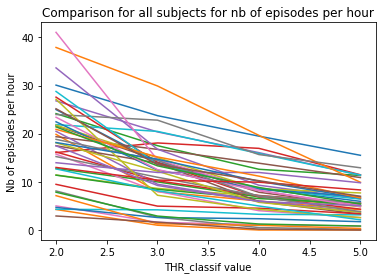

In [5]:
plt.figure()
for elm in results.keys():
    nb_ep=[]
    for ep in results[elm]["reports"]:
        nb_ep.append(ep["Number of episodes per hour"])
    print(elm)
    print(nb_ep[0])
    st = elm.split(os.path.sep)[-1] + " len " + str(ep["Clean data duration"])
    plt.plot([i+2 for i in range(len(THR_classif))], nb_ep)
plt.title('Comparison for all subjects for nb of episodes per hour')
plt.xlabel('THR_classif value')
plt.ylabel('Nb of episodes per hour')


## Data visualization for the entire cohort for nb bursts as a function of THR_classif value : 

Text(0, 0.5, 'Nb of burst on the recording')

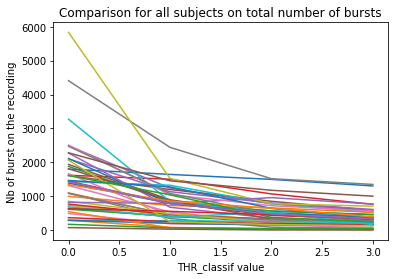

In [6]:
plt.figure()
for elm in results.keys():
    nb_ep=[]
    for ep in results[elm]["reports"]:
        nb_ep.append(ep["Total number of burst"])
    #print(f"Number of bursts for each THR_classif for {elm[-19:]} : {nb_ep}")
    st = elm.split(os.path.sep)[-1] + " len " + str(ep["Clean data duration"])
    plt.plot(nb_ep)
plt.title('Comparison for all subjects on total number of bursts')
plt.xlabel('THR_classif value')
plt.ylabel('Nb of burst on the recording')

## Logs of the preprocessing : 

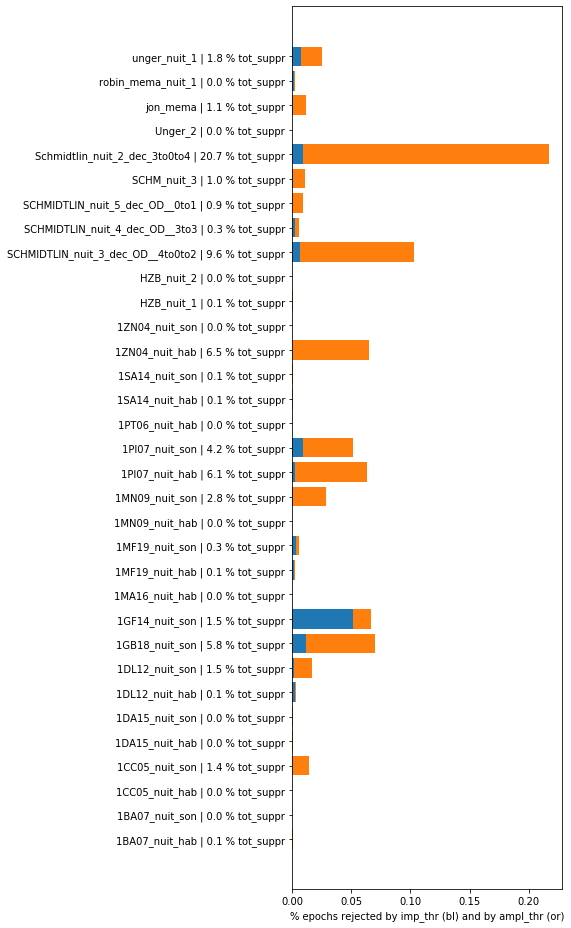

In [7]:
file=[]
suppr_imp=[]
suppr_amp=[]
for elm in results.keys():
    if results[elm]["log"]["bruxism"]['suppressed_overall']/results[elm]["log"]["bruxism"]['total_nb_epochs'] > 0.0001:
        file.append(elm.split(os.path.sep)[-1][:-4] + " | " + 
                    str("%.1f" % (100 *results[elm]["log"]["bruxism"]['suppressed_overall']/results[elm]["log"]["bruxism"]['total_nb_epochs']))
                   + " % tot_suppr")
        suppr_imp.append((results[elm]["log"]["IMP"]['suppressed_overall']/results[elm]["log"]["IMP"]['total_nb_epochs']))
        suppr_amp.append(results[elm]["log"]["bruxism"]['suppressed_overall']/results[elm]["log"]["bruxism"]['total_nb_epochs'])
       


fig, ax = plt.subplots(figsize=(8, 13))
rect1 = ax.barh(file, suppr_imp)
rect2 = ax.barh(file, suppr_amp, left=suppr_imp)
plt.xlabel("% epochs rejected by imp_thr (bl) and by ampl_thr (or)")
plt.tight_layout()
plt.show()


## Extracting list of nb of episodes per hour for all THR_classif per patient

In [95]:
get_scores=[]
for elm in results.keys():
        print (elm)
        l_ep_h=[]
        for ep in results[elm]["reports"]:
            print(ep["Number of episodes per hour"])
            
            l_ep_h.append(ep['Total burst duration'])
        print(ep.keys())

        get_scores.append([elm.split(os.path.sep)[-1], l_ep_h])
print(len(get_scores))
print(get_scores[-3:])

1BA07_nuit_hab.edf
25.007277249993383
14.051708169043902
8.57392362856916
5.954113630950806
dict_keys(['Clean data duration', 'Total burst duration', 'Total number of burst', 'Number of bursts per hour', 'Total number of episodes', 'Number of bursts per episode', 'Number of episodes per hour', 'Number of tonic episodes per hour', 'Number of phasic episodes per hour', 'Number of mixed episodes per hour', 'Mean duration of tonic episode', 'Mean duration of phasic episode', 'Mean duration of mixed episode', 'Power Ratio'])
1BA07_nuit_son.edf
19.866428369861726
7.976671996989935
6.020129809049007
4.214090866334305
dict_keys(['Clean data duration', 'Total burst duration', 'Total number of burst', 'Number of bursts per hour', 'Total number of episodes', 'Number of bursts per episode', 'Number of episodes per hour', 'Number of tonic episodes per hour', 'Number of phasic episodes per hour', 'Number of mixed episodes per hour', 'Mean duration of tonic episode', 'Mean duration of phasic episode'

## Getting masking, VAS-Loudness and  VAS-Intrusiveness data

In [96]:
get_masking = pd.read_csv("data/evol_masquage.csv", delimiter=";")
#print(get_masking)
get_VAS_L = pd.read_csv("data/evol_eva_I.csv", delimiter=";")
#print(get_VAS_L)
get_VAS_I = pd.read_csv("data/evol_eva_G.csv", delimiter=";")
#print(get_VAS_I)

evol_masking = get_masking.values.tolist()[:-4]
evol_VAS_L = get_VAS_L.values.tolist()
evol_VAS_I = get_VAS_I.values.tolist()



## Comparing nb_ep/hour between patients with tinnitus increase (augm) and without (stable) for values of THR_classif

Nb_patients in each group : 
Tinnitus increase : 6
Tinnitus stable : 7
tinnitus decrease : 3
Healthy subjects : 8


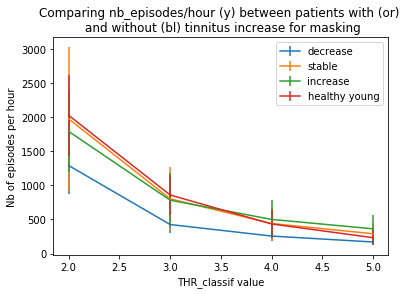

In [97]:
# Files not to consider for analysis
to_suppress=["Schmidtlin_nuit_2_dec_3to0to4.edf", "SCHMIDTLIN_nuit_5_dec_OD__0to1.edf",
             "SCHMIDTLIN_nuit_3_dec_OD__4to0to2.edf","1MA16_nuit_hab.edf","SCHM_nuit_1.edf",
             "HZB_nuit_3.edf",
             "SCHMIDTLIN_nuit_4_dec_OD__3to3.edf",
             '1CC05_nuit_son.edf',
             '1DA15_nuit_son.edf', 
             '1DL12_nuit_son.edf', 
             '1GB18_nuit_son.edf', 
             '1GF14_nuit_son.edf', 
            '1MA16_nuit_son.edf', 
             '1MF19_nuit_son.edf', 
             '1MN09_nuit_son.edf', 
              '1PI07_nuit_son.edf', '1PI07_nuit_hab.edf', 
            '1PT06_nuit_son.edf', 
             '1RA17_nuit_son.edf', 
             '1SA14_nuit_son.edf', 
            '1ZN04_nuit_son.edf'
             ]
patients_sains=['jon_mema.edf','sophie_mema.edf','tom_mema.edf', "robin_nuit_son_24_sept.edf"
               , "robin_nuit_23_sept.edf","robin_mema_nuit_2.edf","robin_mema_nuit_1.edf","jose_mema.edf"]
#Jutification : "Schmidtlin_nuit_2_dec_3to0to4.edf", "SCHMIDTLIN_nuit_1_dec_OD__0to0.edf", 
# "SCHMIDTLIN_nuit_3_dec_OD__4to0to2.edf" : compromised data
# 1MA16_nuit_hab : patient awake all night
# HZB_nuit_3.edf partial night 

#Preparing values for correlation scatter plots
scat=[[] for i in range(len(THR_classif))]  #scatter plots with absolute values
pourc_scat=[[] for i in range(len(THR_classif))]  #scatter plots with percentages values


augm=[[] for i in range(len(THR_classif))]  #patients with tinnitus increase
stable=[[] for i in range(len(THR_classif))] #patients with stable or decreasing tinnitus
decrease = [[] for i in range(len(THR_classif))] #patients with decreasing tinnitus
for elm in evol_masking:
    for i in range(len(get_scores)):
     if not to_suppress.__contains__(elm[0]):
        if elm[0]==get_scores[i][0]:
            
            #For correlation scatter plots
            for j in range(len(THR_classif)):
                #getting points [abs evolution masking volume ; coreesponding nb_episode/hour]
                scat[j].append([elm[-2], get_scores[i][1][j]])
                #if elm[-1] < 1 :  # removing a strong outlier
                    #getting points [% evolution masking volume ; coreesponding nb_episode/hour]
                pourc_scat[j].append([elm[-1], get_scores[i][1][j]])
            
            #Sorting patients according to tinnitus evolution overnight
            if (elm[2]>0.1):
                for j in range(len(THR_classif)):
                    augm[j].append(get_scores[i][1][j])
            else:
                if (elm[2]<-0.1):
                    for j in range(len(THR_classif)):
                        decrease[j].append(get_scores[i][1][j])
                else:
                    for j in range(len(THR_classif)):
                        stable[j].append(get_scores[i][1][j])
            
scores_sains=[[] for i in range(len(THR_classif))]
for elm in get_scores:
    if patients_sains.__contains__(elm[0]):
        for j in range(len(THR_classif)):
            scores_sains[j].append(elm[1][j])
scores_sains_m=[]
scores_sains_std=[]
for elm in scores_sains:
    scores_sains_m.append(np.mean(elm))
    scores_sains_std.append(np.std(elm))
                    
#Calculating mean and standard deviation for all THR_classif values
augm_m=[]
augm_std=[]
stable_m=[]
stable_std=[]
decrease_m=[]
decrease_std=[]
for elm in augm:
    augm_m.append(np.mean(elm))
    augm_std.append(np.std(elm))
for elm in stable:
    stable_m.append(np.mean(elm))
    stable_std.append(np.std(elm))
for elm in decrease:
    decrease_m.append(np.mean(elm))
    decrease_std.append(np.std(elm))
    
print("Nb_patients in each group : ")
print("Tinnitus increase : " + str(len(augm[0])))
print("Tinnitus stable : " + str(len(stable[0])))
print("tinnitus decrease : " + str(len(decrease[0])))
print("Healthy subjects : " + str(len(scores_sains[0])))

    
#Displaying
plt.figure()
plt.errorbar([i+2 for i in range(len(THR_classif))],decrease_m, decrease_std, label = "decrease")
plt.errorbar([i+2 for i in range(len(THR_classif))],stable_m, stable_std, label = "stable")
plt.errorbar([i+2 for i in range(len(THR_classif))], augm_m, augm_std, label = "increase")
plt.errorbar([i+2 for i in range(len(THR_classif))], scores_sains_m, scores_sains_std, label = "healthy young")
plt.title("Comparing nb_episodes/hour (y) between patients with (or) \n and without (bl) tinnitus increase for masking" )
plt.xlabel('THR_classif value')
plt.ylabel('Nb of episodes per hour')
plt.legend()

## Displaying correlation plots for absolute overnight evolutions of tinnitus

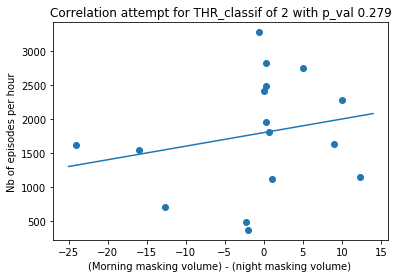

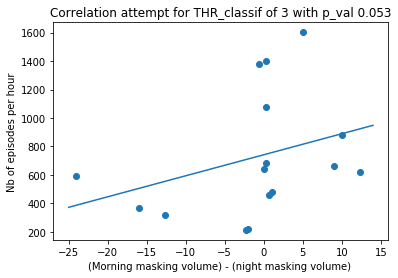

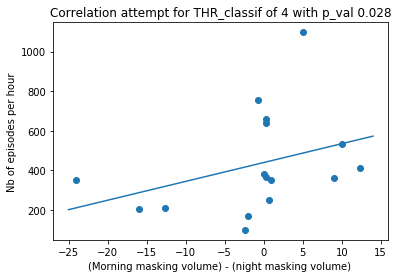

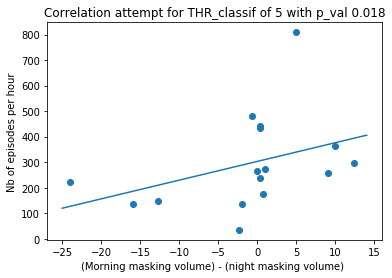

In [98]:
for j in range(len(THR_classif)):  
    tab = np.asanyarray(scat[j])
    tab = tab.transpose()
    #print(j+2)
    
    regre = scipy.stats.linregress(tab[0],tab[1])
    spear = scipy.stats.spearmanr(tab[0],tab[1])
    #print(regre)
    slope=regre[0]
    intercept = regre[1]
    plt.figure()
    plt.scatter(tab[0], tab[1])
    plt.plot([i-25 for i in range(40)],[intercept + slope *(i-25) for i in range(40)])
    #plt.plot([i-1 for i in range(3)],[intercept + slope *(i-1) for i in range(3)])
    plt.title("Correlation attempt for THR_classif of " + str(j+2) + " with p_val "+ str("%.3f" % spear[1]))
    plt.xlabel('(Morning masking volume) - (night masking volume) ')
    plt.ylabel('Nb of episodes per hour')

## Displaying correlation plots for percentage overnight evolutions of tinnitus

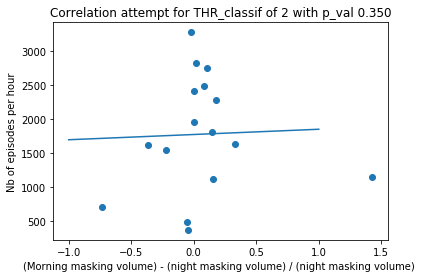

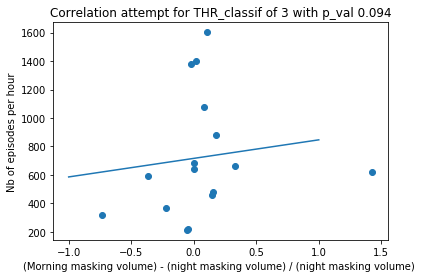

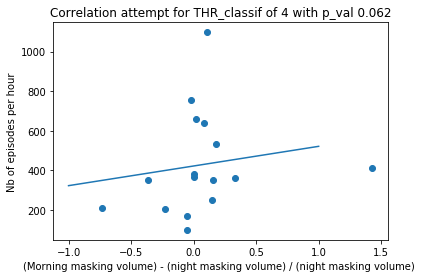

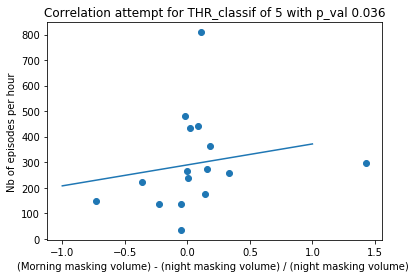

In [99]:
for j in range(len(THR_classif)):
    tab = np.asanyarray(pourc_scat[j])
    tab = tab.transpose()
    regre = scipy.stats.linregress(tab[0],tab[1])
    spear = scipy.stats.spearmanr(tab[0],tab[1])
    slope=regre[0]
    intercept = regre[1]
    plt.figure()
    plt.scatter(tab[0], tab[1])
    plt.plot([i-1 for i in range(3)],[intercept + slope *(i-1) for i in range(3)])
    plt.title("Correlation attempt for THR_classif of " + str(j+2) + " with p_val "+ str("%.3f" % spear[1]))
    plt.xlabel('(Morning masking volume) - (night masking volume) / (night masking volume) ')
    plt.ylabel('Nb of episodes per hour')

## VAS-L

Nb_patients in each group : 
Tinnitus increase : 4
Tinnitus stable : 6
tinnitus decrease : 7
Healthy subjects : 8


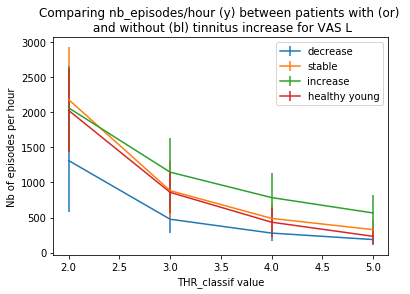

In [100]:
# Files not to consider for analysis
#Jutification : "Schmidtlin_nuit_2_dec_3to0to4.edf", "SCHMIDTLIN_nuit_1_dec_OD__0to0.edf", 
# "SCHMIDTLIN_nuit_3_dec_OD__4to0to2.edf" : compromised data
# 1MA16_nuit_hab : patient awake all night
# HZB_nuit_3.edf partial night 

#Preparing values for correlation scatter plots
scat=[[] for i in range(len(THR_classif))]  #scatter plots with absolute values
pourc_scat=[[] for i in range(len(THR_classif))]  #scatter plots with percentages values


augm=[[] for i in range(len(THR_classif))]  #patients with tinnitus increase
stable=[[] for i in range(len(THR_classif))] #patients with stable or decreasing tinnitus
decrease = [[] for i in range(len(THR_classif))] #patients with decreasing tinnitus
for elm in evol_VAS_L:
    for i in range(len(get_scores)):
     if not to_suppress.__contains__(elm[0]):
        if elm[0]==get_scores[i][0]:
            
            #For correlation scatter plots
            for j in range(len(THR_classif)):
                #getting points [abs evolution masking volume ; coreesponding nb_episode/hour]
                scat[j].append([elm[-2], get_scores[i][1][j]])
                #if elm[-1] < 1 :  # removing a strong outlier
                    #getting points [% evolution masking volume ; coreesponding nb_episode/hour]
                pourc_scat[j].append([elm[-1], get_scores[i][1][j]])
            
            
            #Sorting patients according to tinnitus evolution overnight
            if (elm[2]>0.1):
                for j in range(len(THR_classif)):
                    augm[j].append(get_scores[i][1][j])
            else:
                if (elm[2]<-0.1):
                    for j in range(len(THR_classif)):
                        decrease[j].append(get_scores[i][1][j])
                else:
                    for j in range(len(THR_classif)):
                        stable[j].append(get_scores[i][1][j])
                        
         
                    
#Calculating mean and standard deviation for all THR_classif values
augm_m=[]
augm_std=[]
stable_m=[]
stable_std=[]
decrease_m=[]
decrease_std=[]
for elm in augm:
    augm_m.append(np.mean(elm))
    augm_std.append(np.std(elm))
for elm in stable:
    stable_m.append(np.mean(elm))
    stable_std.append(np.std(elm))
for elm in decrease:
    decrease_m.append(np.mean(elm))
    decrease_std.append(np.std(elm))
    
print("Nb_patients in each group : ")
print("Tinnitus increase : " + str(len(augm[0])))
print("Tinnitus stable : " + str(len(stable[0])))
print("tinnitus decrease : " + str(len(decrease[0])))
print("Healthy subjects : " + str(len(scores_sains[0])))

    
#Displaying
plt.figure()
plt.errorbar([i+2 for i in range(len(THR_classif))],decrease_m, decrease_std, label = "decrease")
plt.errorbar([i+2 for i in range(len(THR_classif))],stable_m, stable_std, label = "stable")
plt.errorbar([i+2 for i in range(len(THR_classif))], augm_m, augm_std, label = "increase")
plt.errorbar([i+2 for i in range(len(THR_classif))], scores_sains_m, scores_sains_std, label = "healthy young")
plt.title("Comparing nb_episodes/hour (y) between patients with (or) \n and without (bl) tinnitus increase for VAS L" )
plt.xlabel('THR_classif value')
plt.ylabel('Nb of episodes per hour')
plt.legend()

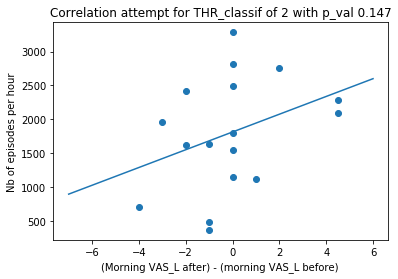

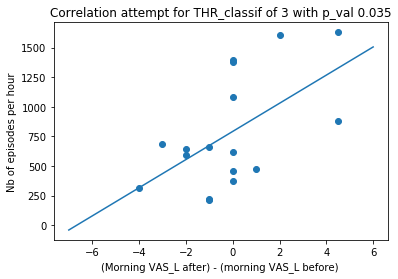

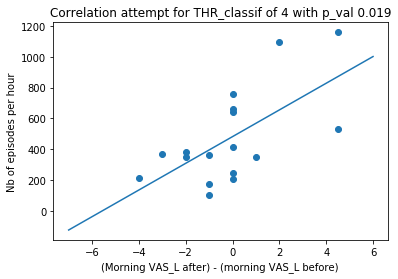

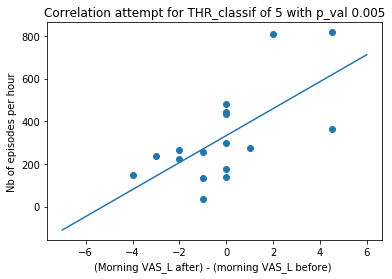

In [101]:
for j in range(len(THR_classif)):  
    tab = np.asanyarray(scat[j])
    tab = tab.transpose()
    #print(j+2)
    
    regre = scipy.stats.linregress(tab[0],tab[1])
    spear = scipy.stats.spearmanr(tab[0],tab[1])
    #print(regre)
    slope=regre[0]
    intercept = regre[1]
    plt.figure()
    plt.scatter(tab[0], tab[1])
    plt.plot([i-7 for i in range(14)],[intercept + slope *(i-7) for i in range(14)])
    #plt.plot([i-1 for i in range(3)],[intercept + slope *(i-1) for i in range(3)])
    plt.title("Correlation attempt for THR_classif of " + str(j+2) + " with p_val "+ str("%.3f" % spear[1]))
    plt.xlabel('(Morning VAS_L after) - (morning VAS_L before) ')
    plt.ylabel('Nb of episodes per hour')

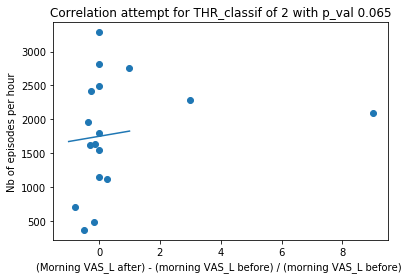

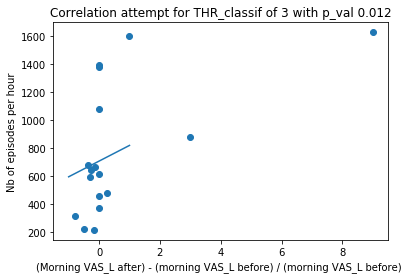

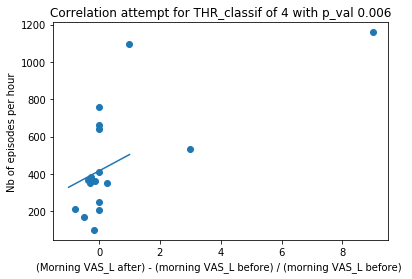

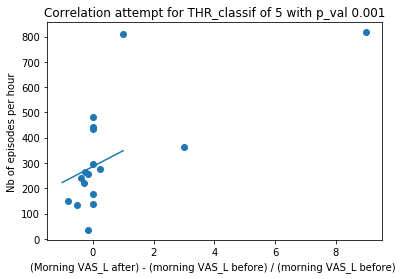

In [102]:
for j in range(len(THR_classif)):
    tab = np.asanyarray(pourc_scat[j])
    tab = tab.transpose()
    regre = scipy.stats.linregress(tab[0],tab[1])
    spear = scipy.stats.spearmanr(tab[0],tab[1])
    slope=regre[0]
    intercept = regre[1]
    plt.figure()
    plt.scatter(tab[0], tab[1])
    plt.plot([i-1 for i in range(3)],[intercept + slope *(i-1) for i in range(3)])
    plt.title("Correlation attempt for THR_classif of " + str(j+2) + " with p_val "+ str("%.3f" % spear[1]))
    plt.xlabel('(Morning VAS_L after) - (morning VAS_L before) / (morning VAS_L before) ')
    plt.ylabel('Nb of episodes per hour')

## VAS_I

Nb_patients in each group : 
Tinnitus increase : 4
Tinnitus stable : 6
tinnitus decrease : 7
Healthy subjects : 8


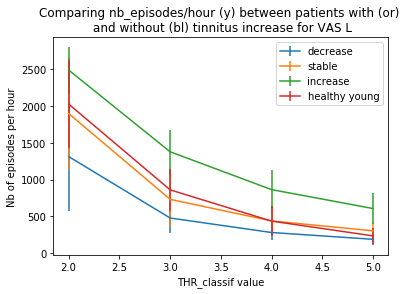

In [103]:
# Files not to consider for analysis

#Jutification : "Schmidtlin_nuit_2_dec_3to0to4.edf", "SCHMIDTLIN_nuit_1_dec_OD__0to0.edf", 
# "SCHMIDTLIN_nuit_3_dec_OD__4to0to2.edf" : compromised data
# 1MA16_nuit_hab : patient awake all night
# HZB_nuit_3.edf partial night 

#Preparing values for correlation scatter plots
scat=[[] for i in range(len(THR_classif))]  #scatter plots with absolute values
pourc_scat=[[] for i in range(len(THR_classif))]  #scatter plots with percentages values


augm=[[] for i in range(len(THR_classif))]  #patients with tinnitus increase
stable=[[] for i in range(len(THR_classif))] #patients with stable or decreasing tinnitus
decrease = [[] for i in range(len(THR_classif))] #patients with decreasing tinnitus
for elm in evol_VAS_I:
    for i in range(len(get_scores)):
     if not to_suppress.__contains__(elm[0]):
        if elm[0]==get_scores[i][0]:
            
            #For correlation scatter plots
            for j in range(len(THR_classif)):
                #getting points [abs evolution masking volume ; coreesponding nb_episode/hour]
                scat[j].append([elm[-2], get_scores[i][1][j]])
                #if elm[-1] < 1 :  # removing a strong outlier
                    #getting points [% evolution masking volume ; coreesponding nb_episode/hour]
                pourc_scat[j].append([elm[-1], get_scores[i][1][j]])
            
            #Sorting patients according to tinnitus evolution overnight
            if (elm[2]>0.1):
                for j in range(len(THR_classif)):
                    augm[j].append(get_scores[i][1][j])
            else:
                if (elm[2]<-0.1):
                    for j in range(len(THR_classif)):
                        decrease[j].append(get_scores[i][1][j])
                else:
                    for j in range(len(THR_classif)):
                        stable[j].append(get_scores[i][1][j])
                        
         
                    
#Calculating mean and standard deviation for all THR_classif values
augm_m=[]
augm_std=[]
stable_m=[]
stable_std=[]
decrease_m=[]
decrease_std=[]
for elm in augm:
    augm_m.append(np.mean(elm))
    augm_std.append(np.std(elm))
for elm in stable:
    stable_m.append(np.mean(elm))
    stable_std.append(np.std(elm))
for elm in decrease:
    decrease_m.append(np.mean(elm))
    decrease_std.append(np.std(elm))
    
print("Nb_patients in each group : ")
print("Tinnitus increase : " + str(len(augm[0])))
print("Tinnitus stable : " + str(len(stable[0])))
print("tinnitus decrease : " + str(len(decrease[0])))
print("Healthy subjects : " + str(len(scores_sains[0])))

    
#Displaying
plt.figure()
plt.errorbar([i+2 for i in range(len(THR_classif))],decrease_m, decrease_std, label = "decrease")
plt.errorbar([i+2 for i in range(len(THR_classif))],stable_m, stable_std, label = "stable")
plt.errorbar([i+2 for i in range(len(THR_classif))], augm_m, augm_std, label = "increase")
plt.errorbar([i+2 for i in range(len(THR_classif))], scores_sains_m, scores_sains_std, label = "healthy young")
plt.title("Comparing nb_episodes/hour (y) between patients with (or) \n and without (bl) tinnitus increase for VAS L" )
plt.xlabel('THR_classif value')
plt.ylabel('Nb of episodes per hour')
plt.legend()

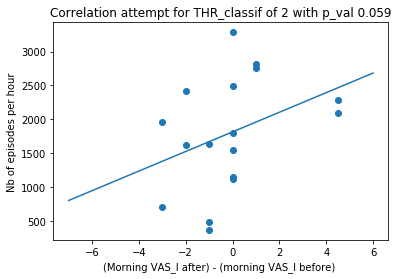

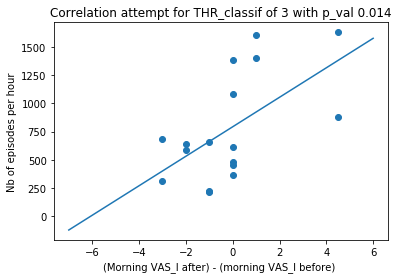

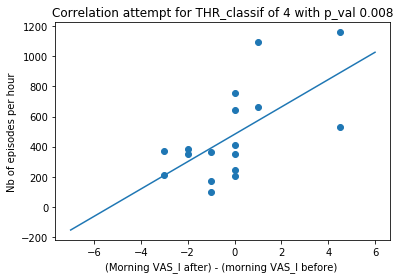

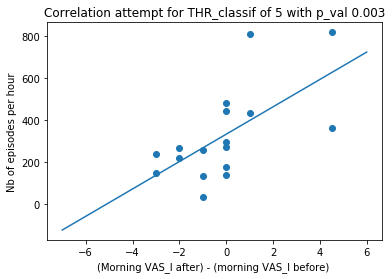

In [104]:
for j in range(len(THR_classif)):  
    tab = np.asanyarray(scat[j])
    tab = tab.transpose()
    #print(j+2)
    
    regre = scipy.stats.linregress(tab[0],tab[1])
    spear = scipy.stats.spearmanr(tab[0],tab[1])
    #print(regre)
    slope=regre[0]
    intercept = regre[1]
    plt.figure()
    plt.scatter(tab[0], tab[1])
    plt.plot([i-7 for i in range(14)],[intercept + slope *(i-7) for i in range(14)])
    #plt.plot([i-1 for i in range(3)],[intercept + slope *(i-1) for i in range(3)])
    plt.title("Correlation attempt for THR_classif of " + str(j+2) + " with p_val "+ str("%.3f" % spear[1]))
    plt.xlabel('(Morning VAS_I after) - (morning VAS_I before) ')
    plt.ylabel('Nb of episodes per hour')

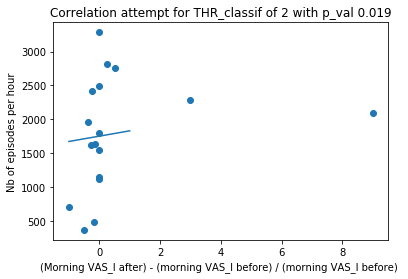

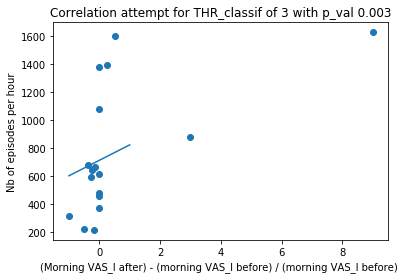

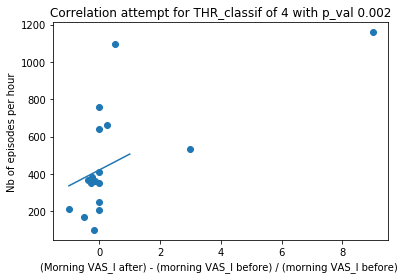

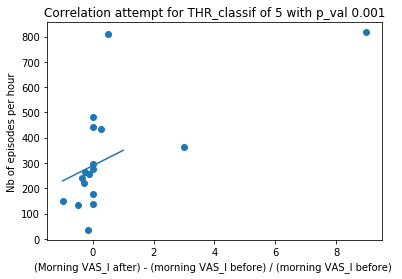

In [105]:
for j in range(len(THR_classif)):
    tab = np.asanyarray(pourc_scat[j])
    tab = tab.transpose()
    regre = scipy.stats.linregress(tab[0],tab[1])
    spear = scipy.stats.spearmanr(tab[0],tab[1])
    slope=regre[0]
    intercept = regre[1]
    plt.figure()
    plt.scatter(tab[0], tab[1])
    plt.plot([i-1 for i in range(3)],[intercept + slope *(i-1) for i in range(3)])
    plt.title("Correlation attempt for THR_classif of " + str(j+2) + " with p_val "+ str("%.3f" % spear[1]))
    plt.xlabel('(Morning VAS_I after) - (morning VAS_I before) / (morning VAS_I before) ')
    plt.ylabel('Nb of episodes per hour')

In [6]:
print(np.array([np.nan]*4))
,
             '1CC05_nuit_son.edf',
             '1DA15_nuit_son.edf', 
             '1DL12_nuit_son.edf', 
             '1GB18_nuit_son.edf', 
             '1GF14_nuit_son.edf', 
            '1MA16_nuit_son.edf', 
             '1MF19_nuit_son.edf', 
             '1MN09_nuit_son.edf', 
              '1PI07_nuit_son.edf', '1PI07_nuit_hab.edf', 
            '1PT06_nuit_son.edf', 
             '1RA17_nuit_son.edf', 
             '1SA14_nuit_son.edf', 
            '1ZN04_nuit_son.edf'


[nan nan nan nan]
